# Classify Leaves
https://www.kaggle.com/competitions/classify-leaves/overview

## 引用相应的库文件

In [1]:
import torch
import My_utils
import torchvision
from torch import nn
import pandas as pd
import os

## 查询树叶类型的总数，并将类型名转为数字

In [2]:
df = pd.read_csv('train.csv')
leaves_types = df['label'].unique()
print(len(leaves_types))
index_list = [i for i in range(len(leaves_types))]
classes_to_num = dict(zip(leaves_types, index_list))
num_to_classes = dict(zip(index_list , leaves_types))
print(classes_to_num)
print(num_to_classes)

176
{'maclura_pomifera': 0, 'ulmus_rubra': 1, 'broussonettia_papyrifera': 2, 'prunus_virginiana': 3, 'acer_rubrum': 4, 'cryptomeria_japonica': 5, 'staphylea_trifolia': 6, 'asimina_triloba': 7, 'diospyros_virginiana': 8, 'tilia_cordata': 9, 'ulmus_pumila': 10, 'quercus_muehlenbergii': 11, 'juglans_cinerea': 12, 'cercis_canadensis': 13, 'ptelea_trifoliata': 14, 'acer_palmatum': 15, 'catalpa_speciosa': 16, 'abies_concolor': 17, 'eucommia_ulmoides': 18, 'quercus_montana': 19, 'koelreuteria_paniculata': 20, 'liriodendron_tulipifera': 21, 'styrax_japonica': 22, 'malus_pumila': 23, 'prunus_sargentii': 24, 'cornus_mas': 25, 'magnolia_virginiana': 26, 'ostrya_virginiana': 27, 'magnolia_acuminata': 28, 'ilex_opaca': 29, 'acer_negundo': 30, 'fraxinus_nigra': 31, 'pyrus_calleryana': 32, 'picea_abies': 33, 'chionanthus_virginicus': 34, 'carpinus_caroliniana': 35, 'zelkova_serrata': 36, 'aesculus_pavi': 37, 'taxodium_distichum': 38, 'carya_tomentosa': 39, 'picea_pungens': 40, 'carya_glabra': 41, 'qu

## 构建迭代器

In [3]:
from torch.utils.data import Dataset
import numpy as np
from PIL import Image
class LeaveDataset(Dataset):
    def __init__(self, csv_path, transform=None, mode='train', train_ratio=0.8):
        super().__init__()
        self.transform = transform
        self.train_ratio = train_ratio
        self.mode = mode
        self.data_info = pd.read_csv(csv_path, header=None)
        self.data_len = len(self.data_info.index) - 1
        self.train_len = int(self.data_len * train_ratio)
        if self.mode == 'train':
            self.image_arr = np.asarray(self.data_info.iloc[1:self.train_len, 0])
            self.label_arr = np.asarray(self.data_info.iloc[1:self.train_len, 1])
        elif self.mode == 'valid':
            self.image_arr = np.asarray(self.data_info.iloc[self.train_len:, 0])
            self.label_arr = np.asarray(self.data_info.iloc[self.train_len:, 1])
        elif self.mode == 'test':
            self.image_arr = np.asarray(self.data_info.iloc[1:, 0])
        self.real_len = len(self.image_arr)
        
    def __getitem__(self, index):
        if self.mode != 'test':
            single_image_name = self.image_arr[index]
            image = Image.open(single_image_name)
            label = self.label_arr[index]
            num_label = classes_to_num[label]
            return self.transform(image), num_label
        else:
            single_image_name = self.image_arr[index]
            image = Image.open(single_image_name)
            return self.transform(image)
    def __len__(self):
        return self.real_len


## 图像增广

In [4]:
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224), # 对图像进行随机的裁剪，最后resize到224*224
    torchvision.transforms.RandomHorizontalFlip(), # 随机水平翻转
    torchvision.transforms.ToTensor(), # 图片是png格式的，要转换为tensor
    normalize
])

valid_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224), # 从中心裁剪处224*224的图片
    torchvision.transforms.ToTensor(),
    normalize
])
train_set = LeaveDataset('train.csv', transform=train_augs, mode='train')
train_iter = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
valid_set = LeaveDataset('train.csv', transform=valid_augs, mode='valid')
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)


## 构建模型

In [5]:
pretrained_net = torchvision.models.resnet18(pretrained=True)
pretrained_net

C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\33143\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 验证模型的效果

loss 0.362, train_acc 0.903, test_acc 0.930
('487.0 examples/sec on ', "[device(type='cuda', index=0)]")


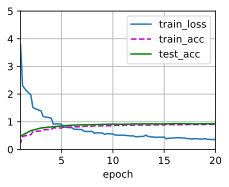

In [6]:
net = torchvision.models.resnet18(pretrained_net)
net.fc = nn.Linear(pretrained_net.fc.in_features, 176)
nn.init.xavier_uniform_(net.fc.weight)
trainer = torch.optim.Adam
num_epochs, lr = 20, 5e-5
My_utils.train_fine_tuning(net, train_iter, valid_iter, trainer, num_epochs, lr)

## 训练并预测生成submission

loss 0.356, train_acc 0.904, test_acc 0.935
('488.6 examples/sec on ', "[device(type='cuda', index=0)]")


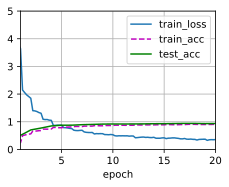

In [7]:
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224), # 从中心裁剪处224*224的图片
    torchvision.transforms.ToTensor(),
    normalize
])
train_set = LeaveDataset('train.csv', transform=train_augs, mode='train')
train_iter = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
valid_set = LeaveDataset('train.csv', transform=test_augs, mode='valid')
valid_iter = torch.utils.data.DataLoader(valid_set, batch_size=100, shuffle=False)
test_set = LeaveDataset('test.csv', transform=test_augs, mode='test')
test_iter = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)
pretrained_net = torchvision.models.resnet18(pretrained=True)
net = torchvision.models.resnet18(pretrained_net)
net.fc = nn.Linear(pretrained_net.fc.in_features, 176)
nn.init.xavier_uniform_(net.fc.weight)
trainer = torch.optim.Adam
num_epochs, lr = 20, 5e-5
My_utils.train_fine_tuning(net, train_iter, valid_iter, trainer, num_epochs, lr)

In [8]:
net.eval()
net = torchvision.models.resnet18(pretrained_net)
net.fc = nn.Linear(pretrained_net.fc.in_features, 176)
net.load_state_dict(torch.load('./pre_res_model.ckpt'))
preds = []
predictions = []
test_set = LeaveDataset('test.csv', transform=test_augs, mode='test')
test_iter = torch.utils.data.DataLoader(test_set, batch_size=8, shuffle=False)
for test_samples in test_iter:
    with torch.no_grad():
        ans = net(test_samples)
        ans = ans.argmax(dim=-1).numpy()
        preds.extend(ans.tolist())
for pred in preds:
    predictions.append(num_to_classes[pred])
df1 = pd.DataFrame(predictions)
df2 = pd.read_csv('test.csv')
df1 = pd.concat([df2, df1], axis=1)
df1.columns = ['image', 'label']
df1.to_csv('submission.csv')